In [3]:
import abtem
import dask
import numpy as np
import scrapbook as sb
from ase.cluster import Decahedron
from dask.distributed import Client
from dask.distributed.deploy.utils import nprocesses_nthreads
from dask.system import CPU_COUNT
from distributed.diagnostics import MemorySampler

In [12]:
gpts = 1024
sampling = 0.05
num_configs = None
n_workers = None
threads_per_worker = None
fft_threads = 2
interpolation = None

In [13]:
if interpolation is None:
    interpolation = max(gpts // 256, 1)

if num_configs is None:
    num_configs = max(8192 // gpts, 1)

dask_threads = CPU_COUNT // fft_threads
n_workers, threads_per_worker = nprocesses_nthreads(dask_threads)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x [Å]', ylabel='y [Å]'>)

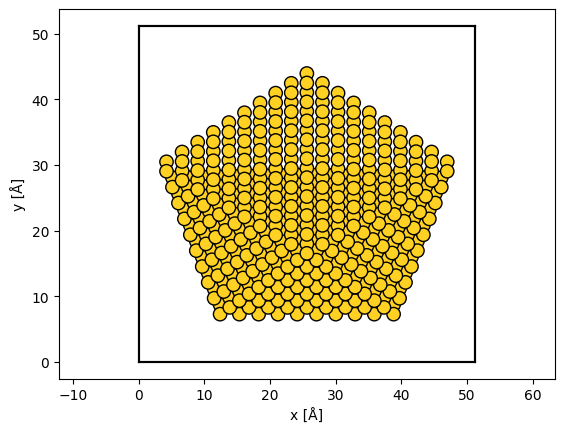

In [14]:
extent = gpts * sampling
slope = 0.19908323698251337

p = int(np.floor(slope * extent))
q = max(p // 4, 2)

atoms = Decahedron("Au", p, q, 0)
atoms.rotate("x", 30)
atoms.cell[0, 0] = atoms.cell[1, 1] = extent
atoms.center()
atoms.center(axis=2, vacuum=4)

abtem.show_atoms(atoms)

In [15]:
client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker)
client

C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58880 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58880/status,
Dashboard: http://127.0.0.1:58880/status,Workers: 4
Total threads: 8,Total memory: 31.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58883,Workers: 4
Dashboard: http://127.0.0.1:58880/status,Total threads: 8
Started: Just now,Total memory: 31.93 GiB
Comm: tcp://127.0.0.1:58910,Total threads: 2
Dashboard: http://127.0.0.1:58911/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:58888,


In [16]:
frozen_phonons = abtem.FrozenPhonons(
    atoms, num_configs=num_configs, sigmas=0.1, ensemble_mean=True
)

potential = abtem.Potential(
    frozen_phonons, gpts=gpts, slice_thickness=2, projection="infinite"
)
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=100e3,
    semiangle_cutoff=20,
    downsample=True,
    interpolation=1,#(4,4),
)

detector = abtem.AnnularDetector(inner=80, outer=240)
detector = abtem.FlexibleAnnularDetector()

scan = abtem.GridScan()

scan.match_probe(s_matrix)

s_matrix.cutoff_angles

(246.52146073009635, 246.52146073009635)

In [9]:
measurements = s_matrix.reduce(scan=scan, detectors=detector)

In [10]:
memory_sampler = MemorySampler()

In [11]:
%%timeit -n1 -r1 -o
with memory_sampler.sample():
    with abtem.config.set({"fftw.threads": fft_threads}):
        measurements.compute()

4min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 4min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

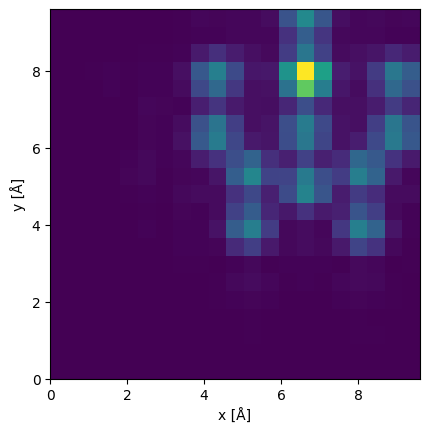

In [104]:
measurements.show()

In [10]:
timeit_result = _

In [18]:
time_per_phonon = timeit_result.average / num_configs
print("Time per phonon", time_per_phonon, "s")

Time per phonon 0.8190219656249837 s


<AxesSubplot: xlabel='time', ylabel='Cluster memory (GiB)'>

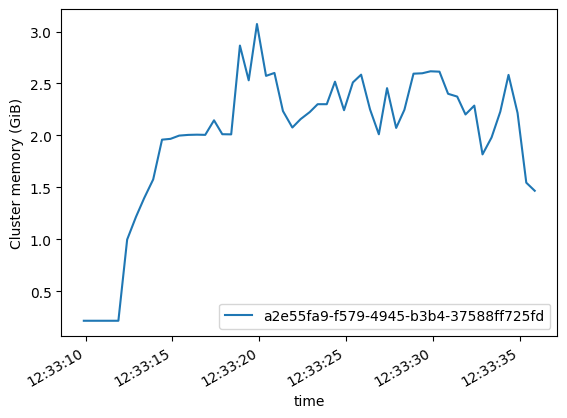

In [12]:
memory_sampler.plot()

In [19]:
peak_memory = max([memory for time, memory in list(memory_sampler.samples.values())[0]])
peak_memory = peak_memory * 9.31323e-10
print("Peak memory", peak_memory, "GiB")

Peak memory 3.072438689722368 GiB


In [15]:
sb.glue("time_per_phonon", time_per_phonon)
sb.glue("peak_memory", peak_memory)
sb.glue("num_probe_positions", int(np.prod(scan.shape)))

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

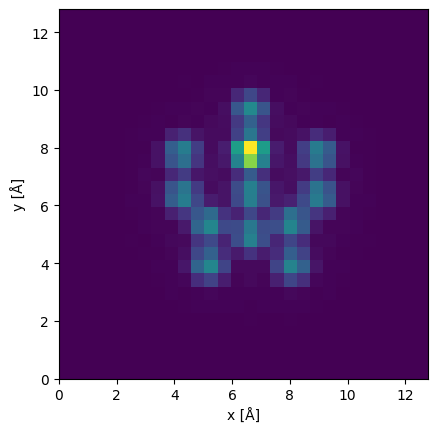

In [16]:
measurements.show()